# Introduction

This notebook presents **SAGAN: Self-Attention GAN** implementation as the final project of the "Introduction to Deep Learning" course in the MSDS program.  

Within the MSDS course, there was another project focused on CycleGAN, and I really enjoyed working on that project.  

Because of that experience, I decided to take on **SAGAN** for this final project --- building upon what I learned from CycleGAN while also exploring the Attention mechanism, which has become an essential part of many modern deep learning applications.  

SAGAN not only incorporates the Attention mechanism, but also implements important and fascinating techniques such as **pointwise convolution** and **spectral normalization**.  

Although fully understanding these technique is no easy task, I am determined to grasp them firmly through hands-on implementation.  

The ultimate goal of the notebook is to generate **handwritten digit images similar to MNIST** using SAGAN.  

To reduce computational cost, I will focus only on images labeled as '7' and '8' from the MNIST dataset.

# Download the MNIST

In [1]:
# For loading data

import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

# For SAGAN implementation
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# prepare a directory
data_dir = './data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
from sklearn.datasets import fetch_openml

# downloadinig the famous MNIST(28×28=784)
# option:
# as_frame=False: loading data in NumPy array format; we want this because we handle image data rather than table data
# as_frame=True : loading data in pandas DataFrame format
mnist = fetch_openml('mnist_784', version=1, data_home='./data/', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# Fetching data
X = mnist.data
y = mnist.target

The label of this image is "5".


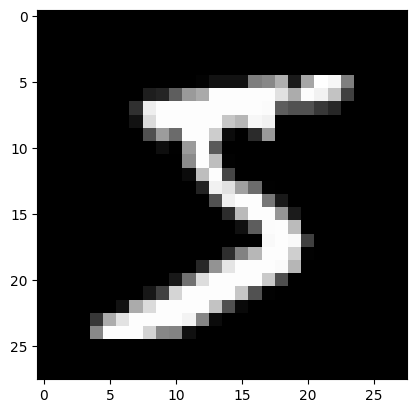

In [5]:
# Visualizing the first one in our dataset
plt.imshow(X[0].reshape(28,28), cmap='gray')
print('The label of this image is "{}".'.format(y[0]))

In [6]:
# adding another directory
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [7]:
# saving "7" and "8" images into a directory "img_78"
count7 = 0
count8 = 0
max_num = 200  # 200 images each

for i in range(len(X)):

    # saving '7' images into the directory 
    if (y[i] == "7") and (count7<max_num):
        file_path = "./data/img_78/img_7_"+str(count7)+".jpg"
        im_f = (X[i].reshape(28, 28))  # transform the image into the shape 28x28
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # image to PIL format
        # SAGAN will generate 64x64 image, thus the training data is adjusted accordingly.
        # BICUBIC: image interpolation method which is the best among interpolation methods {Nearest neighbor, BiLinear, BiCubic}
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)
        pil_img_f.save(file_path)
        count7 += 1

    # saving '8' images
    if (y[i] == '8') and (count8<max_num):
        file_path = "./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # transforming the image into shape 28x28
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) # transforming data type to integer
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # expand to 64x64
        pil_img_f.save(file_path)
        count8 += 1        

In [8]:
# Setup seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# SAGAN Module

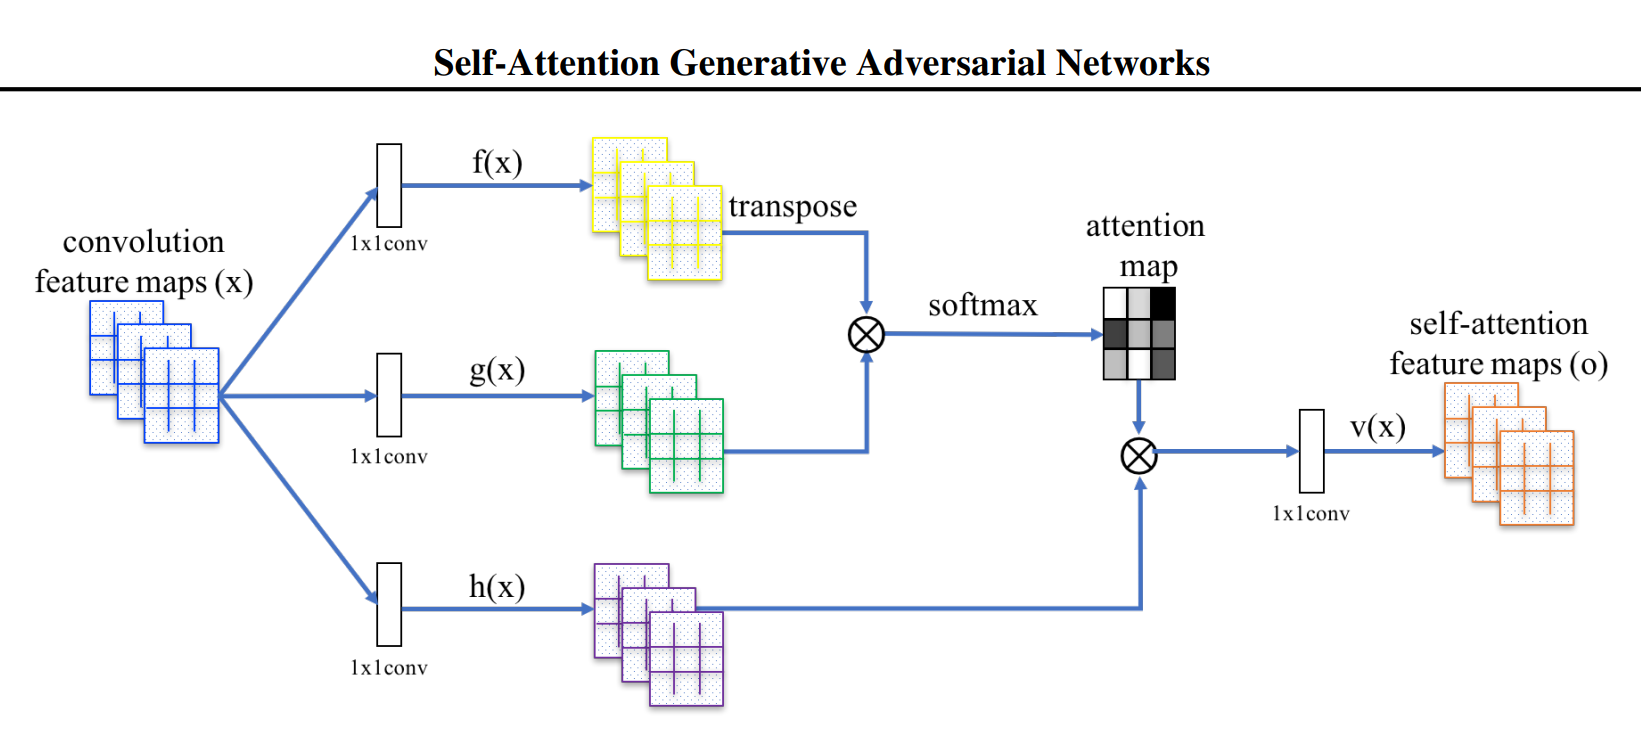
The figure is excerpted from the Self-Attention GAN paper.  

If we replace $f(x)$ with "key", $g(x)$ with "query", and $h(x)$ with "value" in the figure, we can see that this is exactly the same attention mechanism found in papers such as Transformer.  

The formula for the Scaled Dot-Product Attention used in Transformer, 
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt D})V$$

is directly represented in the figure.

Resource:  
Self-Attention Generative Adversarial Networks  
arXiv:1805.08318

# Differences between Self Attention and Cross Attention

The transformer architecture includes both **Self Attention** and **Cross Attention** mechanisms.  
Some models, such as BERT and SAGAN, only use Self Attention, but here we will briefly clarify the differences between the two.  

### Self Attention
Self Attention is a mechanism that compares different parts within the same input data to capture relationships.  
In the case of images, it calculates how much one pixel (or patch) relates to other pixels within the same features.  
Because it refers to itself within the same state, it is called Self Attention.  

### Cross Attention
Cross Attention, on the other hand, compares different data sources.  
For example, in the Transformer architecture, Cross Attention is used when the Decoder refers to the features extracted by the Encoder.  
More specifically, the Encoder uses Self Attention to extract features from the input data, and the Decoder uses those features, along with the model's own previous outputs, to make predictions and generates outputs.  

### Common Point
Both Self Attention and Cross Attention share the same core computation:
They both calculate the inner product between Query and Key.

In [9]:
class Self_Attention(nn.Module):
    """Self Attention Layer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # Pointwise Convolution
        # (explained in the Markdown cell below)
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
            
        # softmax scaling for the attention map
        # S = q^T k -> shape: (N_query, N_key)
        # Softmax(dim=-2) applies softmax along the 2nd-to-last dimension
        # which is query axis in this case.
        # Example attention map after applying softmax;
        #          key_1 key_2 key_3
        # query_1   0.5   0.3   0.2
        # query_2   0.2   0.7   0.1
        # query_3   0.4   0.1   0.5
        self.softmax = nn.Softmax(dim=-2)
    
        # gamma: hyperparameter coefficient for self attention map. 
        # output = x + gamma * o
        # If gamma = 0, there is no effect of self attention.
        # If gamma = 1, the output of self attention is added as is.
        # If gamma > 1, the weight of self attention has more effect.
        # Through the training, model will learn how much weight it should apply on self attention.
        # default setting: gamma = 0
    
        # nn.Parameter() defines a learnable paramete in neural network.
        # Since gamma is a scalar coefficient, we initialize it as a tensor with a single element (1).
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        X = x
    
        # convolute, then reshape: view() is a reshape function for tensor
        # reshaping query size from [B, C, H, W] to [B, C, N] where N = HxW
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [Batch_size, Channel, N]
        # transposing proj_query
        proj_query = proj_query.permute(0, 2, 1) # [B, N, C]
        # key as same as query
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [B, C, N]
    
        # bmm(): batch matrix multiplication; multiplying matrix in each batch
        S = torch.bmm(proj_query, proj_key)
    
        # normalizing the attention to [0, 1] range
        # attention_map = self.softmax(S) 
        attention_map_T = self.softmax(S)  # 行i(Query)方向の和を1にするｿﾌﾄﾏｯｸｽ
        attention_map = attention_map_T.permute(0,2,1)  # 転置を取る
        
        # deriving self attention map
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [B,C,H,W]->[B,C,N]
        o = torch.bmm(proj_value, attention_map.permute(
                      0, 2, 1))
    
        # reshape o: self attention map to the size of X tensor
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        # attention being added to the input x
        # gamma scales the weight of attention
        out = x + self.gamma * o
    
        return out, attention_map

# Pointwise Convolution
This technique became widely known through the paper **Network in Network**.  

It involves inserting a 1x1 convolution layer between standard convolution layers in a CNN.  

This allows for increasing or decreasing the number of channels **without changing the spatial dimentions** of the feature map.  

Reducing the number of channels while keeping the image size the same leads to two main benefits:  
- Feature compression
- Reduced computational cost  

This structure is often referred to as a **bottleneck block**, and it is frequently used in optimized CNN architectures to improve efficiency.  

Resource:
Network in network,  
Min Lin, Qiang Chen, Shuicheng Yan.  
arXiv:1312.4400

# Generator

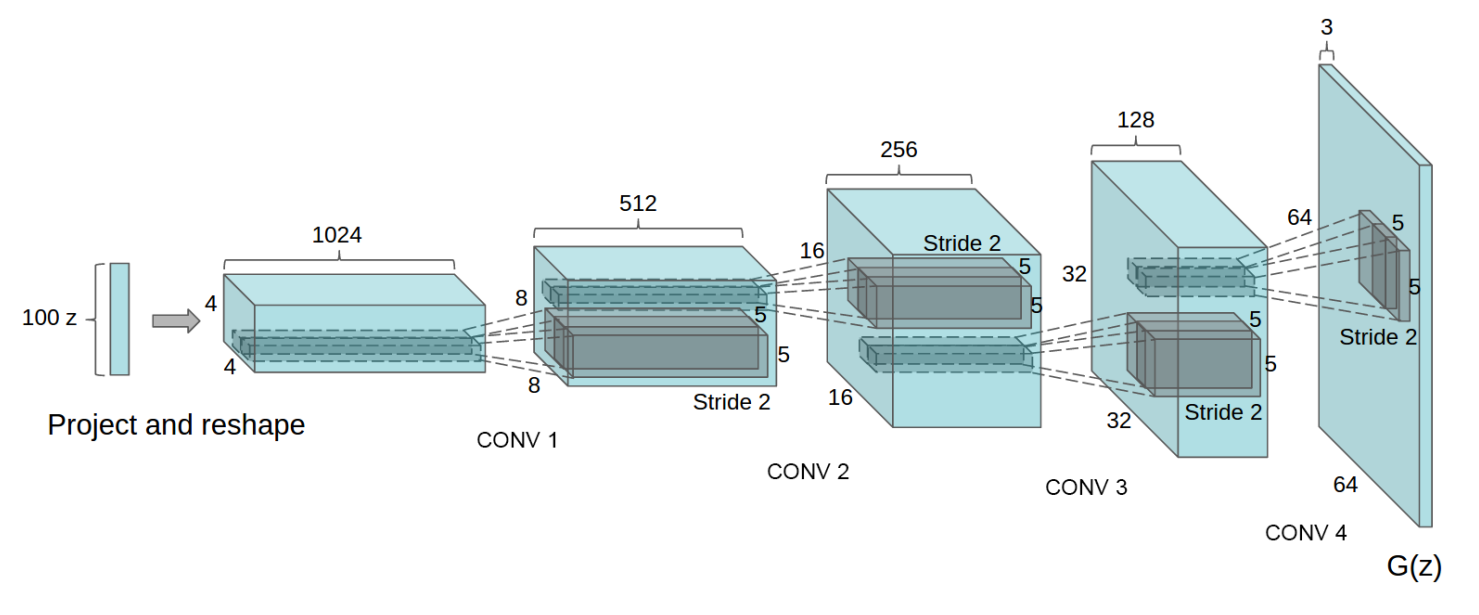
The figure is excerpted from the DCGAN paper.  

The generator takes a random vector as the seed and gradually generates an image of the desired size by repeatedly applying transposed convolutions.

Our generator is composed of five convolutional layers, similar to the architecture shown in the figure.  

The key difference are that our 4th and 5th convolutional layers incorporate attention mechanisms, the input noise vector is 20-dimensional instead of 100-dimensional, and the final layer outputs a single channel instead of three.  

This design choice reflects our focus on generating **grayscale** and **relatively simple digit images**, allowing us to reduce computational complexity while maintaining effective learning. 

Resource:  
Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (DCGAN)  
Alec Radford & Luke Metz, Soumith Chintala  
arXiv:1511.06434

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        # input size: (B:1,Ch:20,H:1,W:1)
        self.layer1 = nn.Sequential(
            # Applying Spectral Normalilzation
            # (explained in the Markdown cell below)
            # ConvTranspose2d(in_ch,out_ch,ker_size,stride,padding)
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        # input size: (1,512,4,4)
        self.layer2 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8, image_size*4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        # input size: (1,256,8,8)
        self.layer3 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))

        # Adding Self Attention layer
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        # input size: (1,128,16,16)
        self.layer4 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Adding Self Attention layer
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        # input size: (1,64,32,32)
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())

        # output size: (1,1,64,64)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2 

# Spectral Normalization
Spectral Normalization standardizes the network's weight parameters (in contrast to Batch Normalization, which normalizes the input data).  

For a GAN to function effectively, the **Discriminator** must satisfy **Lipschitz continuity**.  

Lipschitz continuity means that small changes in the image lead to only small changes in the Discriminator's output.  

Conversely, if small changes in the input cause large, erratic changes in the output, the GAN fails to learn properly.  

To enforce Lipshitz continuity, Spectral Normalization divides each layer's weight parameters by their largest singular value, ensuring that the input tensor to a layer does not get excessively amplified in the output tensor.



### Let's check how the generator is working

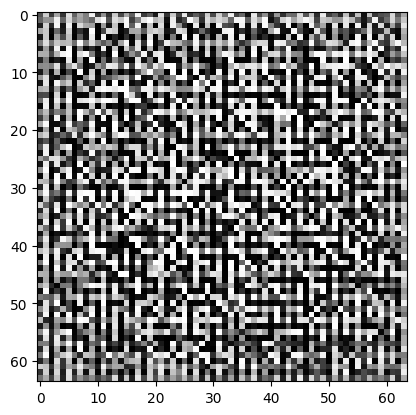

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# input noise
input_z = torch.randn(1, 20)

# resize the tensor to (batch_size=1, ch=20, H=1, W=1)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# output a generated image
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, cmap='gray')
plt.show()

As expected, the generator outputs a noisy image since it hasn't been trained yet (no weights have been updated).  
Still, it's working correctly in the sense that it produces output that can be passed to the discriminator.

# Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
    
        self.layer1 = nn.Sequential(
            # Adding Spectral Normalilzation
            # Conv2d(in_ch,out_ch,ker_size,stride,padding)
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, 
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        self.layer2 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, 
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        self.layer3 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4,
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        # Adding Self Attention layer
        self.self_attention1 = Self_Attention(in_dim=image_size*4)
    
        self.layer4 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8,
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        # Adding Self Attention layer
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
    
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
    
        return out, attention_map1, attention_map2

### Let's check how the discriminator is working

In [13]:
D = Discriminator(z_dim=20, image_size=64)

# Generating a fake image
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# Feeding a fake image into D
d_out, attention_map1, attention_map2 = D(fake_images)
print('d_out', d_out)

# Normalizing D's output to [0,1] range by Sigmoid function
print(nn.Sigmoid()(d_out))

d_out tensor([[[[-0.0539]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[0.4865]]]], grad_fn=<SigmoidBackward0>)


Output：  
d_out: -0.0539 (close to zero)  

This is the raw score, or logit, output by the Discriminator.  

When a logit close to zero is converted to a probability using the **sigmoid** function, the result is close to 0.5 (in this case, 0.4865).  

Since the Discriminator is untrained at this stage, it cannot yet distinguish real from fake images well -- so it tends to give probabilities around 0.5, effectively making random guesses.

# DataLoader

In [14]:
def make_datapath_list():
    """Preparing a filepath list for training and evaluating image data as well as the attention data"""
    train_img_list = list() # store an imagefile path

    for img_idx in range(200):
        img_path = './data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

        img_path = './data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [15]:
class ImageTransform():
    """Image preprocessing"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [16]:
class GAN_Img_Dataset(data.Dataset):
    """Image dataset class; inherits PyTorch Dataset class"""
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        """return # of images"""
        return len(self.file_list)

    def __getitem__(self, index):
        """Obtain the preprocessed image data in Tensor format"""

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # image preprocessing
        img_transformed = self.transform(img)

        return img_transformed

In [17]:
# instantiating DataLoader

# preparing file list
train_img_list = make_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list = train_img_list, transform = ImageTransform(mean, std))

# DataLoader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# Let's test the dataloader
batch_iterator = iter(train_dataloader)  # transform to an iterator
imges = next(batch_iterator)  # getting the first element
print(imges.size())

torch.Size([64, 1, 64, 64])


# Training

In [18]:
# function to train a model
def train_model(G, D, dataloader, num_epochs):
    # checking GPU availability
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device', device)

    # optimizer setting
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # Define loss function 
    #  -> switched to hinge version of adversarial loss
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # hyperparameters
    z_dim = 20
    mini_batch_size = 64

    # allocating the network to GPU
    G.to(device)
    D.to(device)

    G.train() # setting training mode
    D.train() # setting training mode

    # If the network is static, it can be fasten.
    torch.backends.cudnn.benchmark = True

    # number of images
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # iteration counter
    iteration = 1
    logs = []

    # epoch loop
    for epoch in range(num_epochs):
        # measure time (start time)
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 # sum of loss of an epoch
        epoch_d_loss = 0.0 # sum of loss of an epoch

        print('-------------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------------')
        print(' (train) ')

        # loops taking minibatches from the dataloader
        for i, images in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}')):

            # if GPU is available:
            images = images.to(device)

            # The discriminator training
            # checking a batch size
            mini_batch_size = images.size()[0]
            # labeling '1' for real images, '0' for fake images 
            # label_real = torch.full((mini_batch_size,), 1).to(device)
            # label_fake = torch.full((mini_batch_size,), 0).to(device)

            # Let the discriminator label for 'real image'.
            d_out_real, _, _ = D(images)

            # Generating random noise `input_z` 
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            # view() means reshape the tensor.
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            # Feeding it into the generator to generate `fake image'
            fake_images, _, _ = G(input_z)
            # Let the discriminator label for 'fake image'.
            d_out_fake, _, _ = D(fake_images)

            # calculating loss for real-images and fake-images, and sum them up
            #  -> switched to hinge version of adversarial loss
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_real.view(-1), label_fake)
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # if d_out_real is greater than 1, the loss will be 0.
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # if d_out_fake is lesser than -1, the loss will be 0.
            
            d_loss = d_loss_real + d_loss_fake
            
            # initializing gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            # backpropatation
            d_loss.backward()  
            # updating parameters
            d_optimizer.step() 

            # The generator training
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            # view() means reshape the tensor
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            # Feeding it into G to generate `fake image'
            fake_images, _, _ = G(input_z)
            # Let D label for 'fake image'.
            d_out_fake, _, _ = D(fake_images)

            # loss calculation
            g_loss = -d_out_fake.mean()

            # backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # keep record
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # The loss and accuracy rate per epoch phase
        t_epoch_finish = time.time()
        print('-------------------')
        print('epoch {} || Epoch_D_loss:{:.4f} ||Epoch_G_loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

These specific initialization values (in below cell) aren't backed by solid theory, but they've been shown to help in practice -- especially for GANs like DCGAN and SAGAN. So while not mandatory, they're often used to improve performance and training stability.

In [19]:
# Initializing network
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initializing Conv2d and ConvTranspose2d
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # Initializing BatchNorm2d
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# executing initialization
# G.apply(weights_init)
# D.apply(weights_init)

# print('network initialization completed!')

In [20]:
# executing initialization
G.apply(weights_init)
D.apply(weights_init)

# Train and validate
# maybe took about 15 minutes
# num_epochs = 300
num_epochs = 170

G_update, D_update = train_model(
    G, D, dataloader = train_dataloader, num_epochs=num_epochs)

device cuda:0
-------------------
Epoch 0/170
-------------------
 (train) 


Epoch 1: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


-------------------
epoch 0 || Epoch_D_loss:0.1499 ||Epoch_G_loss:0.0984
timer: 5.7529 sec.
-------------------
Epoch 1/170
-------------------
 (train) 


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


-------------------
epoch 1 || Epoch_D_loss:0.1094 ||Epoch_G_loss:0.0534
timer: 1.1199 sec.
-------------------
Epoch 2/170
-------------------
 (train) 


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


-------------------
epoch 2 || Epoch_D_loss:0.1079 ||Epoch_G_loss:0.0409
timer: 1.1112 sec.
-------------------
Epoch 3/170
-------------------
 (train) 


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


-------------------
epoch 3 || Epoch_D_loss:0.1341 ||Epoch_G_loss:-0.0073
timer: 1.1030 sec.
-------------------
Epoch 4/170
-------------------
 (train) 


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


-------------------
epoch 4 || Epoch_D_loss:0.0862 ||Epoch_G_loss:0.0565
timer: 1.1089 sec.
-------------------
Epoch 5/170
-------------------
 (train) 


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


-------------------
epoch 5 || Epoch_D_loss:0.1011 ||Epoch_G_loss:0.0448
timer: 1.0999 sec.
-------------------
Epoch 6/170
-------------------
 (train) 


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


-------------------
epoch 6 || Epoch_D_loss:0.0004 ||Epoch_G_loss:0.1443
timer: 1.0884 sec.
-------------------
Epoch 7/170
-------------------
 (train) 


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


-------------------
epoch 7 || Epoch_D_loss:0.0002 ||Epoch_G_loss:0.1428
timer: 1.0814 sec.
-------------------
Epoch 8/170
-------------------
 (train) 


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


-------------------
epoch 8 || Epoch_D_loss:0.0859 ||Epoch_G_loss:0.0779
timer: 1.1068 sec.
-------------------
Epoch 9/170
-------------------
 (train) 


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


-------------------
epoch 9 || Epoch_D_loss:0.0576 ||Epoch_G_loss:0.1040
timer: 1.1038 sec.
-------------------
Epoch 10/170
-------------------
 (train) 


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


-------------------
epoch 10 || Epoch_D_loss:0.0973 ||Epoch_G_loss:0.0940
timer: 1.1093 sec.
-------------------
Epoch 11/170
-------------------
 (train) 


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


-------------------
epoch 11 || Epoch_D_loss:0.1094 ||Epoch_G_loss:0.1332
timer: 1.1079 sec.
-------------------
Epoch 12/170
-------------------
 (train) 


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


-------------------
epoch 12 || Epoch_D_loss:0.0642 ||Epoch_G_loss:0.1147
timer: 1.1000 sec.
-------------------
Epoch 13/170
-------------------
 (train) 


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


-------------------
epoch 13 || Epoch_D_loss:0.0537 ||Epoch_G_loss:0.1069
timer: 1.1003 sec.
-------------------
Epoch 14/170
-------------------
 (train) 


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


-------------------
epoch 14 || Epoch_D_loss:0.0666 ||Epoch_G_loss:0.1141
timer: 1.1035 sec.
-------------------
Epoch 15/170
-------------------
 (train) 


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


-------------------
epoch 15 || Epoch_D_loss:0.0795 ||Epoch_G_loss:0.0901
timer: 1.1020 sec.
-------------------
Epoch 16/170
-------------------
 (train) 


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


-------------------
epoch 16 || Epoch_D_loss:0.0872 ||Epoch_G_loss:0.1246
timer: 1.1049 sec.
-------------------
Epoch 17/170
-------------------
 (train) 


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


-------------------
epoch 17 || Epoch_D_loss:0.0949 ||Epoch_G_loss:0.0693
timer: 1.1016 sec.
-------------------
Epoch 18/170
-------------------
 (train) 


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


-------------------
epoch 18 || Epoch_D_loss:0.0997 ||Epoch_G_loss:0.0842
timer: 1.1104 sec.
-------------------
Epoch 19/170
-------------------
 (train) 


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


-------------------
epoch 19 || Epoch_D_loss:0.0966 ||Epoch_G_loss:0.0470
timer: 1.1072 sec.
-------------------
Epoch 20/170
-------------------
 (train) 


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


-------------------
epoch 20 || Epoch_D_loss:0.1121 ||Epoch_G_loss:0.1005
timer: 1.1259 sec.
-------------------
Epoch 21/170
-------------------
 (train) 


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


-------------------
epoch 21 || Epoch_D_loss:0.1198 ||Epoch_G_loss:0.0823
timer: 1.1232 sec.
-------------------
Epoch 22/170
-------------------
 (train) 


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


-------------------
epoch 22 || Epoch_D_loss:0.1096 ||Epoch_G_loss:0.0876
timer: 1.1051 sec.
-------------------
Epoch 23/170
-------------------
 (train) 


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


-------------------
epoch 23 || Epoch_D_loss:0.1127 ||Epoch_G_loss:0.0671
timer: 1.1144 sec.
-------------------
Epoch 24/170
-------------------
 (train) 


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


-------------------
epoch 24 || Epoch_D_loss:0.1322 ||Epoch_G_loss:0.0617
timer: 1.1284 sec.
-------------------
Epoch 25/170
-------------------
 (train) 


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


-------------------
epoch 25 || Epoch_D_loss:0.1452 ||Epoch_G_loss:0.0664
timer: 1.1202 sec.
-------------------
Epoch 26/170
-------------------
 (train) 


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


-------------------
epoch 26 || Epoch_D_loss:0.1493 ||Epoch_G_loss:0.0428
timer: 1.1186 sec.
-------------------
Epoch 27/170
-------------------
 (train) 


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


-------------------
epoch 27 || Epoch_D_loss:0.1473 ||Epoch_G_loss:0.0471
timer: 1.1205 sec.
-------------------
Epoch 28/170
-------------------
 (train) 


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


-------------------
epoch 28 || Epoch_D_loss:0.1495 ||Epoch_G_loss:0.0735
timer: 1.1275 sec.
-------------------
Epoch 29/170
-------------------
 (train) 


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


-------------------
epoch 29 || Epoch_D_loss:0.1670 ||Epoch_G_loss:0.0647
timer: 1.1331 sec.
-------------------
Epoch 30/170
-------------------
 (train) 


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


-------------------
epoch 30 || Epoch_D_loss:0.1550 ||Epoch_G_loss:0.0891
timer: 1.1320 sec.
-------------------
Epoch 31/170
-------------------
 (train) 


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


-------------------
epoch 31 || Epoch_D_loss:0.1998 ||Epoch_G_loss:0.0844
timer: 1.1185 sec.
-------------------
Epoch 32/170
-------------------
 (train) 


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


-------------------
epoch 32 || Epoch_D_loss:0.1654 ||Epoch_G_loss:0.0657
timer: 1.1302 sec.
-------------------
Epoch 33/170
-------------------
 (train) 


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


-------------------
epoch 33 || Epoch_D_loss:0.1813 ||Epoch_G_loss:0.0355
timer: 1.1273 sec.
-------------------
Epoch 34/170
-------------------
 (train) 


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


-------------------
epoch 34 || Epoch_D_loss:0.1909 ||Epoch_G_loss:0.0116
timer: 1.1327 sec.
-------------------
Epoch 35/170
-------------------
 (train) 


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


-------------------
epoch 35 || Epoch_D_loss:0.1542 ||Epoch_G_loss:0.0334
timer: 1.1361 sec.
-------------------
Epoch 36/170
-------------------
 (train) 


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


-------------------
epoch 36 || Epoch_D_loss:0.2035 ||Epoch_G_loss:0.0171
timer: 1.1322 sec.
-------------------
Epoch 37/170
-------------------
 (train) 


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


-------------------
epoch 37 || Epoch_D_loss:0.1997 ||Epoch_G_loss:0.0033
timer: 1.1286 sec.
-------------------
Epoch 38/170
-------------------
 (train) 


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


-------------------
epoch 38 || Epoch_D_loss:0.1814 ||Epoch_G_loss:0.0283
timer: 1.1354 sec.
-------------------
Epoch 39/170
-------------------
 (train) 


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


-------------------
epoch 39 || Epoch_D_loss:0.1861 ||Epoch_G_loss:0.0446
timer: 1.1316 sec.
-------------------
Epoch 40/170
-------------------
 (train) 


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


-------------------
epoch 40 || Epoch_D_loss:0.1654 ||Epoch_G_loss:0.0353
timer: 1.1395 sec.
-------------------
Epoch 41/170
-------------------
 (train) 


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


-------------------
epoch 41 || Epoch_D_loss:0.2014 ||Epoch_G_loss:0.0446
timer: 1.1315 sec.
-------------------
Epoch 42/170
-------------------
 (train) 


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


-------------------
epoch 42 || Epoch_D_loss:0.1916 ||Epoch_G_loss:0.0363
timer: 1.1376 sec.
-------------------
Epoch 43/170
-------------------
 (train) 


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


-------------------
epoch 43 || Epoch_D_loss:0.1921 ||Epoch_G_loss:-0.0007
timer: 1.1398 sec.
-------------------
Epoch 44/170
-------------------
 (train) 


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


-------------------
epoch 44 || Epoch_D_loss:0.2147 ||Epoch_G_loss:0.0563
timer: 1.1304 sec.
-------------------
Epoch 45/170
-------------------
 (train) 


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


-------------------
epoch 45 || Epoch_D_loss:0.1765 ||Epoch_G_loss:0.0589
timer: 1.1425 sec.
-------------------
Epoch 46/170
-------------------
 (train) 


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


-------------------
epoch 46 || Epoch_D_loss:0.2007 ||Epoch_G_loss:0.0476
timer: 1.1397 sec.
-------------------
Epoch 47/170
-------------------
 (train) 


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


-------------------
epoch 47 || Epoch_D_loss:0.1937 ||Epoch_G_loss:0.0342
timer: 1.1361 sec.
-------------------
Epoch 48/170
-------------------
 (train) 


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


-------------------
epoch 48 || Epoch_D_loss:0.1774 ||Epoch_G_loss:0.0446
timer: 1.1649 sec.
-------------------
Epoch 49/170
-------------------
 (train) 


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


-------------------
epoch 49 || Epoch_D_loss:0.1930 ||Epoch_G_loss:0.0385
timer: 1.1458 sec.
-------------------
Epoch 50/170
-------------------
 (train) 


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


-------------------
epoch 50 || Epoch_D_loss:0.1717 ||Epoch_G_loss:0.0667
timer: 1.1532 sec.
-------------------
Epoch 51/170
-------------------
 (train) 


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


-------------------
epoch 51 || Epoch_D_loss:0.1845 ||Epoch_G_loss:0.0157
timer: 1.1442 sec.
-------------------
Epoch 52/170
-------------------
 (train) 


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


-------------------
epoch 52 || Epoch_D_loss:0.1886 ||Epoch_G_loss:0.0406
timer: 1.1413 sec.
-------------------
Epoch 53/170
-------------------
 (train) 


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


-------------------
epoch 53 || Epoch_D_loss:0.1889 ||Epoch_G_loss:0.0367
timer: 1.1477 sec.
-------------------
Epoch 54/170
-------------------
 (train) 


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


-------------------
epoch 54 || Epoch_D_loss:0.1810 ||Epoch_G_loss:0.0522
timer: 1.1528 sec.
-------------------
Epoch 55/170
-------------------
 (train) 


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


-------------------
epoch 55 || Epoch_D_loss:0.1728 ||Epoch_G_loss:0.0379
timer: 1.1445 sec.
-------------------
Epoch 56/170
-------------------
 (train) 


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


-------------------
epoch 56 || Epoch_D_loss:0.1808 ||Epoch_G_loss:0.0776
timer: 1.1488 sec.
-------------------
Epoch 57/170
-------------------
 (train) 


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


-------------------
epoch 57 || Epoch_D_loss:0.1897 ||Epoch_G_loss:0.0130
timer: 1.1478 sec.
-------------------
Epoch 58/170
-------------------
 (train) 


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


-------------------
epoch 58 || Epoch_D_loss:0.1816 ||Epoch_G_loss:0.0382
timer: 1.1456 sec.
-------------------
Epoch 59/170
-------------------
 (train) 


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


-------------------
epoch 59 || Epoch_D_loss:0.1881 ||Epoch_G_loss:0.0474
timer: 1.1506 sec.
-------------------
Epoch 60/170
-------------------
 (train) 


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


-------------------
epoch 60 || Epoch_D_loss:0.1764 ||Epoch_G_loss:0.0470
timer: 1.1492 sec.
-------------------
Epoch 61/170
-------------------
 (train) 


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


-------------------
epoch 61 || Epoch_D_loss:0.1682 ||Epoch_G_loss:0.0662
timer: 1.1577 sec.
-------------------
Epoch 62/170
-------------------
 (train) 


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


-------------------
epoch 62 || Epoch_D_loss:0.1851 ||Epoch_G_loss:0.0409
timer: 1.1523 sec.
-------------------
Epoch 63/170
-------------------
 (train) 


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


-------------------
epoch 63 || Epoch_D_loss:0.1818 ||Epoch_G_loss:0.0362
timer: 1.1579 sec.
-------------------
Epoch 64/170
-------------------
 (train) 


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


-------------------
epoch 64 || Epoch_D_loss:0.1813 ||Epoch_G_loss:0.0481
timer: 1.1530 sec.
-------------------
Epoch 65/170
-------------------
 (train) 


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


-------------------
epoch 65 || Epoch_D_loss:0.1667 ||Epoch_G_loss:0.0450
timer: 1.1564 sec.
-------------------
Epoch 66/170
-------------------
 (train) 


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


-------------------
epoch 66 || Epoch_D_loss:0.1886 ||Epoch_G_loss:0.0210
timer: 1.1479 sec.
-------------------
Epoch 67/170
-------------------
 (train) 


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


-------------------
epoch 67 || Epoch_D_loss:0.1759 ||Epoch_G_loss:0.0402
timer: 1.1565 sec.
-------------------
Epoch 68/170
-------------------
 (train) 


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


-------------------
epoch 68 || Epoch_D_loss:0.1790 ||Epoch_G_loss:0.0512
timer: 1.1552 sec.
-------------------
Epoch 69/170
-------------------
 (train) 


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


-------------------
epoch 69 || Epoch_D_loss:0.1665 ||Epoch_G_loss:0.0547
timer: 1.1560 sec.
-------------------
Epoch 70/170
-------------------
 (train) 


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


-------------------
epoch 70 || Epoch_D_loss:0.1769 ||Epoch_G_loss:0.0350
timer: 1.1545 sec.
-------------------
Epoch 71/170
-------------------
 (train) 


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


-------------------
epoch 71 || Epoch_D_loss:0.1779 ||Epoch_G_loss:0.0427
timer: 1.1684 sec.
-------------------
Epoch 72/170
-------------------
 (train) 


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


-------------------
epoch 72 || Epoch_D_loss:0.1809 ||Epoch_G_loss:0.0599
timer: 1.1505 sec.
-------------------
Epoch 73/170
-------------------
 (train) 


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


-------------------
epoch 73 || Epoch_D_loss:0.1666 ||Epoch_G_loss:0.0364
timer: 1.1573 sec.
-------------------
Epoch 74/170
-------------------
 (train) 


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


-------------------
epoch 74 || Epoch_D_loss:0.1754 ||Epoch_G_loss:0.0469
timer: 1.1579 sec.
-------------------
Epoch 75/170
-------------------
 (train) 


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 75 || Epoch_D_loss:0.1798 ||Epoch_G_loss:0.0537
timer: 1.1737 sec.
-------------------
Epoch 76/170
-------------------
 (train) 


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


-------------------
epoch 76 || Epoch_D_loss:0.1717 ||Epoch_G_loss:0.0435
timer: 1.1619 sec.
-------------------
Epoch 77/170
-------------------
 (train) 


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


-------------------
epoch 77 || Epoch_D_loss:0.1800 ||Epoch_G_loss:0.0462
timer: 1.1558 sec.
-------------------
Epoch 78/170
-------------------
 (train) 


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


-------------------
epoch 78 || Epoch_D_loss:0.1783 ||Epoch_G_loss:0.0368
timer: 1.1514 sec.
-------------------
Epoch 79/170
-------------------
 (train) 


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


-------------------
epoch 79 || Epoch_D_loss:0.1616 ||Epoch_G_loss:0.0460
timer: 1.1663 sec.
-------------------
Epoch 80/170
-------------------
 (train) 


Epoch 81: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


-------------------
epoch 80 || Epoch_D_loss:0.1661 ||Epoch_G_loss:0.0154
timer: 1.1659 sec.
-------------------
Epoch 81/170
-------------------
 (train) 


Epoch 82: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


-------------------
epoch 81 || Epoch_D_loss:0.1849 ||Epoch_G_loss:0.0502
timer: 1.1597 sec.
-------------------
Epoch 82/170
-------------------
 (train) 


Epoch 83: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


-------------------
epoch 82 || Epoch_D_loss:0.1793 ||Epoch_G_loss:0.0193
timer: 1.1609 sec.
-------------------
Epoch 83/170
-------------------
 (train) 


Epoch 84: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


-------------------
epoch 83 || Epoch_D_loss:0.1723 ||Epoch_G_loss:0.0405
timer: 1.1686 sec.
-------------------
Epoch 84/170
-------------------
 (train) 


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


-------------------
epoch 84 || Epoch_D_loss:0.1534 ||Epoch_G_loss:0.0592
timer: 1.1644 sec.
-------------------
Epoch 85/170
-------------------
 (train) 


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


-------------------
epoch 85 || Epoch_D_loss:0.1805 ||Epoch_G_loss:0.0356
timer: 1.1621 sec.
-------------------
Epoch 86/170
-------------------
 (train) 


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


-------------------
epoch 86 || Epoch_D_loss:0.1851 ||Epoch_G_loss:0.0462
timer: 1.1629 sec.
-------------------
Epoch 87/170
-------------------
 (train) 


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


-------------------
epoch 87 || Epoch_D_loss:0.1721 ||Epoch_G_loss:0.0359
timer: 1.1648 sec.
-------------------
Epoch 88/170
-------------------
 (train) 


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


-------------------
epoch 88 || Epoch_D_loss:0.1515 ||Epoch_G_loss:0.0617
timer: 1.1666 sec.
-------------------
Epoch 89/170
-------------------
 (train) 


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


-------------------
epoch 89 || Epoch_D_loss:0.1788 ||Epoch_G_loss:0.0182
timer: 1.1810 sec.
-------------------
Epoch 90/170
-------------------
 (train) 


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]


-------------------
epoch 90 || Epoch_D_loss:0.1805 ||Epoch_G_loss:0.0614
timer: 1.1483 sec.
-------------------
Epoch 91/170
-------------------
 (train) 


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


-------------------
epoch 91 || Epoch_D_loss:0.1693 ||Epoch_G_loss:0.0671
timer: 1.1687 sec.
-------------------
Epoch 92/170
-------------------
 (train) 


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


-------------------
epoch 92 || Epoch_D_loss:0.1706 ||Epoch_G_loss:0.0419
timer: 1.1662 sec.
-------------------
Epoch 93/170
-------------------
 (train) 


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


-------------------
epoch 93 || Epoch_D_loss:0.1717 ||Epoch_G_loss:0.0443
timer: 1.1654 sec.
-------------------
Epoch 94/170
-------------------
 (train) 


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


-------------------
epoch 94 || Epoch_D_loss:0.1662 ||Epoch_G_loss:0.0439
timer: 1.1601 sec.
-------------------
Epoch 95/170
-------------------
 (train) 


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


-------------------
epoch 95 || Epoch_D_loss:0.1606 ||Epoch_G_loss:0.0598
timer: 1.1646 sec.
-------------------
Epoch 96/170
-------------------
 (train) 


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


-------------------
epoch 96 || Epoch_D_loss:0.1584 ||Epoch_G_loss:0.0471
timer: 1.1675 sec.
-------------------
Epoch 97/170
-------------------
 (train) 


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


-------------------
epoch 97 || Epoch_D_loss:0.1754 ||Epoch_G_loss:0.0288
timer: 1.1665 sec.
-------------------
Epoch 98/170
-------------------
 (train) 


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


-------------------
epoch 98 || Epoch_D_loss:0.1700 ||Epoch_G_loss:0.0523
timer: 1.1658 sec.
-------------------
Epoch 99/170
-------------------
 (train) 


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


-------------------
epoch 99 || Epoch_D_loss:0.1521 ||Epoch_G_loss:0.0524
timer: 1.1708 sec.
-------------------
Epoch 100/170
-------------------
 (train) 


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


-------------------
epoch 100 || Epoch_D_loss:0.1514 ||Epoch_G_loss:0.0156
timer: 1.1626 sec.
-------------------
Epoch 101/170
-------------------
 (train) 


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 101 || Epoch_D_loss:0.1736 ||Epoch_G_loss:0.0506
timer: 1.1733 sec.
-------------------
Epoch 102/170
-------------------
 (train) 


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


-------------------
epoch 102 || Epoch_D_loss:0.1550 ||Epoch_G_loss:0.0478
timer: 1.1939 sec.
-------------------
Epoch 103/170
-------------------
 (train) 


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


-------------------
epoch 103 || Epoch_D_loss:0.1624 ||Epoch_G_loss:0.0317
timer: 1.1793 sec.
-------------------
Epoch 104/170
-------------------
 (train) 


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 104 || Epoch_D_loss:0.1579 ||Epoch_G_loss:0.0583
timer: 1.1724 sec.
-------------------
Epoch 105/170
-------------------
 (train) 


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 105 || Epoch_D_loss:0.1583 ||Epoch_G_loss:0.0499
timer: 1.1727 sec.
-------------------
Epoch 106/170
-------------------
 (train) 


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


-------------------
epoch 106 || Epoch_D_loss:0.1647 ||Epoch_G_loss:0.0403
timer: 1.1722 sec.
-------------------
Epoch 107/170
-------------------
 (train) 


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


-------------------
epoch 107 || Epoch_D_loss:0.1508 ||Epoch_G_loss:0.0584
timer: 1.1779 sec.
-------------------
Epoch 108/170
-------------------
 (train) 


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 108 || Epoch_D_loss:0.1588 ||Epoch_G_loss:0.0423
timer: 1.1830 sec.
-------------------
Epoch 109/170
-------------------
 (train) 


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


-------------------
epoch 109 || Epoch_D_loss:0.1531 ||Epoch_G_loss:0.0488
timer: 1.1756 sec.
-------------------
Epoch 110/170
-------------------
 (train) 


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 110 || Epoch_D_loss:0.1542 ||Epoch_G_loss:0.0536
timer: 1.1743 sec.
-------------------
Epoch 111/170
-------------------
 (train) 


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 111 || Epoch_D_loss:0.1603 ||Epoch_G_loss:0.0471
timer: 1.1805 sec.
-------------------
Epoch 112/170
-------------------
 (train) 


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 112 || Epoch_D_loss:0.1413 ||Epoch_G_loss:0.0779
timer: 1.1799 sec.
-------------------
Epoch 113/170
-------------------
 (train) 


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 113 || Epoch_D_loss:0.1502 ||Epoch_G_loss:0.0532
timer: 1.1734 sec.
-------------------
Epoch 114/170
-------------------
 (train) 


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 114 || Epoch_D_loss:0.1497 ||Epoch_G_loss:0.0492
timer: 1.1740 sec.
-------------------
Epoch 115/170
-------------------
 (train) 


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


-------------------
epoch 115 || Epoch_D_loss:0.1519 ||Epoch_G_loss:0.0584
timer: 1.1763 sec.
-------------------
Epoch 116/170
-------------------
 (train) 


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


-------------------
epoch 116 || Epoch_D_loss:0.1427 ||Epoch_G_loss:0.0441
timer: 1.1816 sec.
-------------------
Epoch 117/170
-------------------
 (train) 


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


-------------------
epoch 117 || Epoch_D_loss:0.1565 ||Epoch_G_loss:0.0676
timer: 1.1746 sec.
-------------------
Epoch 118/170
-------------------
 (train) 


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


-------------------
epoch 118 || Epoch_D_loss:0.1472 ||Epoch_G_loss:0.0682
timer: 1.1690 sec.
-------------------
Epoch 119/170
-------------------
 (train) 


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


-------------------
epoch 119 || Epoch_D_loss:0.1449 ||Epoch_G_loss:0.0661
timer: 1.1763 sec.
-------------------
Epoch 120/170
-------------------
 (train) 


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 120 || Epoch_D_loss:0.1204 ||Epoch_G_loss:0.0661
timer: 1.1795 sec.
-------------------
Epoch 121/170
-------------------
 (train) 


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


-------------------
epoch 121 || Epoch_D_loss:0.1540 ||Epoch_G_loss:0.0605
timer: 1.1740 sec.
-------------------
Epoch 122/170
-------------------
 (train) 


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


-------------------
epoch 122 || Epoch_D_loss:0.1478 ||Epoch_G_loss:0.0579
timer: 1.1709 sec.
-------------------
Epoch 123/170
-------------------
 (train) 


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


-------------------
epoch 123 || Epoch_D_loss:0.1480 ||Epoch_G_loss:0.0546
timer: 1.1767 sec.
-------------------
Epoch 124/170
-------------------
 (train) 


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


-------------------
epoch 124 || Epoch_D_loss:0.1380 ||Epoch_G_loss:0.0606
timer: 1.1696 sec.
-------------------
Epoch 125/170
-------------------
 (train) 


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


-------------------
epoch 125 || Epoch_D_loss:0.1414 ||Epoch_G_loss:0.0561
timer: 1.1705 sec.
-------------------
Epoch 126/170
-------------------
 (train) 


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 126 || Epoch_D_loss:0.1401 ||Epoch_G_loss:0.0615
timer: 1.1786 sec.
-------------------
Epoch 127/170
-------------------
 (train) 


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


-------------------
epoch 127 || Epoch_D_loss:0.1394 ||Epoch_G_loss:0.0687
timer: 1.1822 sec.
-------------------
Epoch 128/170
-------------------
 (train) 


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


-------------------
epoch 128 || Epoch_D_loss:0.1393 ||Epoch_G_loss:0.0657
timer: 1.1780 sec.
-------------------
Epoch 129/170
-------------------
 (train) 


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


-------------------
epoch 129 || Epoch_D_loss:0.1406 ||Epoch_G_loss:0.0696
timer: 1.2021 sec.
-------------------
Epoch 130/170
-------------------
 (train) 


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 130 || Epoch_D_loss:0.1395 ||Epoch_G_loss:0.0715
timer: 1.1913 sec.
-------------------
Epoch 131/170
-------------------
 (train) 


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


-------------------
epoch 131 || Epoch_D_loss:0.1329 ||Epoch_G_loss:0.0704
timer: 1.1853 sec.
-------------------
Epoch 132/170
-------------------
 (train) 


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 132 || Epoch_D_loss:0.1399 ||Epoch_G_loss:0.0664
timer: 1.1784 sec.
-------------------
Epoch 133/170
-------------------
 (train) 


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


-------------------
epoch 133 || Epoch_D_loss:0.1181 ||Epoch_G_loss:0.0836
timer: 1.1841 sec.
-------------------
Epoch 134/170
-------------------
 (train) 


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 134 || Epoch_D_loss:0.1486 ||Epoch_G_loss:0.0607
timer: 1.1799 sec.
-------------------
Epoch 135/170
-------------------
 (train) 


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


-------------------
epoch 135 || Epoch_D_loss:0.1297 ||Epoch_G_loss:0.0733
timer: 1.1804 sec.
-------------------
Epoch 136/170
-------------------
 (train) 


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


-------------------
epoch 136 || Epoch_D_loss:0.1274 ||Epoch_G_loss:0.0583
timer: 1.1885 sec.
-------------------
Epoch 137/170
-------------------
 (train) 


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 137 || Epoch_D_loss:0.1400 ||Epoch_G_loss:0.0699
timer: 1.1789 sec.
-------------------
Epoch 138/170
-------------------
 (train) 


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


-------------------
epoch 138 || Epoch_D_loss:0.1313 ||Epoch_G_loss:0.0502
timer: 1.1873 sec.
-------------------
Epoch 139/170
-------------------
 (train) 


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 139 || Epoch_D_loss:0.1337 ||Epoch_G_loss:0.0735
timer: 1.1789 sec.
-------------------
Epoch 140/170
-------------------
 (train) 


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 140 || Epoch_D_loss:0.1339 ||Epoch_G_loss:0.0563
timer: 1.1908 sec.
-------------------
Epoch 141/170
-------------------
 (train) 


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 141 || Epoch_D_loss:0.1259 ||Epoch_G_loss:0.0642
timer: 1.1839 sec.
-------------------
Epoch 142/170
-------------------
 (train) 


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 142 || Epoch_D_loss:0.1275 ||Epoch_G_loss:0.0574
timer: 1.1839 sec.
-------------------
Epoch 143/170
-------------------
 (train) 


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 143 || Epoch_D_loss:0.1043 ||Epoch_G_loss:0.0692
timer: 1.1807 sec.
-------------------
Epoch 144/170
-------------------
 (train) 


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


-------------------
epoch 144 || Epoch_D_loss:0.1419 ||Epoch_G_loss:0.0869
timer: 1.1847 sec.
-------------------
Epoch 145/170
-------------------
 (train) 


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 145 || Epoch_D_loss:0.1309 ||Epoch_G_loss:0.0617
timer: 1.1842 sec.
-------------------
Epoch 146/170
-------------------
 (train) 


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


-------------------
epoch 146 || Epoch_D_loss:0.1099 ||Epoch_G_loss:0.0720
timer: 1.1846 sec.
-------------------
Epoch 147/170
-------------------
 (train) 


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 147 || Epoch_D_loss:0.1367 ||Epoch_G_loss:0.0871
timer: 1.1909 sec.
-------------------
Epoch 148/170
-------------------
 (train) 


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


-------------------
epoch 148 || Epoch_D_loss:0.1374 ||Epoch_G_loss:0.0692
timer: 1.1993 sec.
-------------------
Epoch 149/170
-------------------
 (train) 


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


-------------------
epoch 149 || Epoch_D_loss:0.1350 ||Epoch_G_loss:0.0947
timer: 1.1812 sec.
-------------------
Epoch 150/170
-------------------
 (train) 


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


-------------------
epoch 150 || Epoch_D_loss:0.1227 ||Epoch_G_loss:0.0702
timer: 1.1758 sec.
-------------------
Epoch 151/170
-------------------
 (train) 


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


-------------------
epoch 151 || Epoch_D_loss:0.1218 ||Epoch_G_loss:0.0745
timer: 1.1901 sec.
-------------------
Epoch 152/170
-------------------
 (train) 


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


-------------------
epoch 152 || Epoch_D_loss:0.1271 ||Epoch_G_loss:0.0904
timer: 1.1883 sec.
-------------------
Epoch 153/170
-------------------
 (train) 


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 153 || Epoch_D_loss:0.1225 ||Epoch_G_loss:0.0608
timer: 1.1904 sec.
-------------------
Epoch 154/170
-------------------
 (train) 


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


-------------------
epoch 154 || Epoch_D_loss:0.1211 ||Epoch_G_loss:0.0773
timer: 1.1876 sec.
-------------------
Epoch 155/170
-------------------
 (train) 


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


-------------------
epoch 155 || Epoch_D_loss:0.1086 ||Epoch_G_loss:0.0777
timer: 1.1928 sec.
-------------------
Epoch 156/170
-------------------
 (train) 


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


-------------------
epoch 156 || Epoch_D_loss:0.1214 ||Epoch_G_loss:0.0893
timer: 1.1971 sec.
-------------------
Epoch 157/170
-------------------
 (train) 


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 157 || Epoch_D_loss:0.1135 ||Epoch_G_loss:0.0810
timer: 1.1909 sec.
-------------------
Epoch 158/170
-------------------
 (train) 


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


-------------------
epoch 158 || Epoch_D_loss:0.1181 ||Epoch_G_loss:0.0876
timer: 1.1779 sec.
-------------------
Epoch 159/170
-------------------
 (train) 


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 159 || Epoch_D_loss:0.1148 ||Epoch_G_loss:0.0831
timer: 1.1859 sec.
-------------------
Epoch 160/170
-------------------
 (train) 


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


-------------------
epoch 160 || Epoch_D_loss:0.1172 ||Epoch_G_loss:0.0846
timer: 1.1836 sec.
-------------------
Epoch 161/170
-------------------
 (train) 


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


-------------------
epoch 161 || Epoch_D_loss:0.1167 ||Epoch_G_loss:0.0720
timer: 1.1865 sec.
-------------------
Epoch 162/170
-------------------
 (train) 


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


-------------------
epoch 162 || Epoch_D_loss:0.1119 ||Epoch_G_loss:0.0831
timer: 1.1878 sec.
-------------------
Epoch 163/170
-------------------
 (train) 


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


-------------------
epoch 163 || Epoch_D_loss:0.1135 ||Epoch_G_loss:0.1023
timer: 1.1946 sec.
-------------------
Epoch 164/170
-------------------
 (train) 


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


-------------------
epoch 164 || Epoch_D_loss:0.1104 ||Epoch_G_loss:0.0705
timer: 1.1990 sec.
-------------------
Epoch 165/170
-------------------
 (train) 


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 165 || Epoch_D_loss:0.1043 ||Epoch_G_loss:0.1013
timer: 1.1916 sec.
-------------------
Epoch 166/170
-------------------
 (train) 


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


-------------------
epoch 166 || Epoch_D_loss:0.1140 ||Epoch_G_loss:0.0740
timer: 1.1926 sec.
-------------------
Epoch 167/170
-------------------
 (train) 


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


-------------------
epoch 167 || Epoch_D_loss:0.1165 ||Epoch_G_loss:0.0902
timer: 1.1971 sec.
-------------------
Epoch 168/170
-------------------
 (train) 


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


-------------------
epoch 168 || Epoch_D_loss:0.1109 ||Epoch_G_loss:0.0981
timer: 1.1861 sec.
-------------------
Epoch 169/170
-------------------
 (train) 


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]

-------------------
epoch 169 || Epoch_D_loss:0.1132 ||Epoch_G_loss:0.0924
timer: 1.1942 sec.


# Mode Collapse occurred!

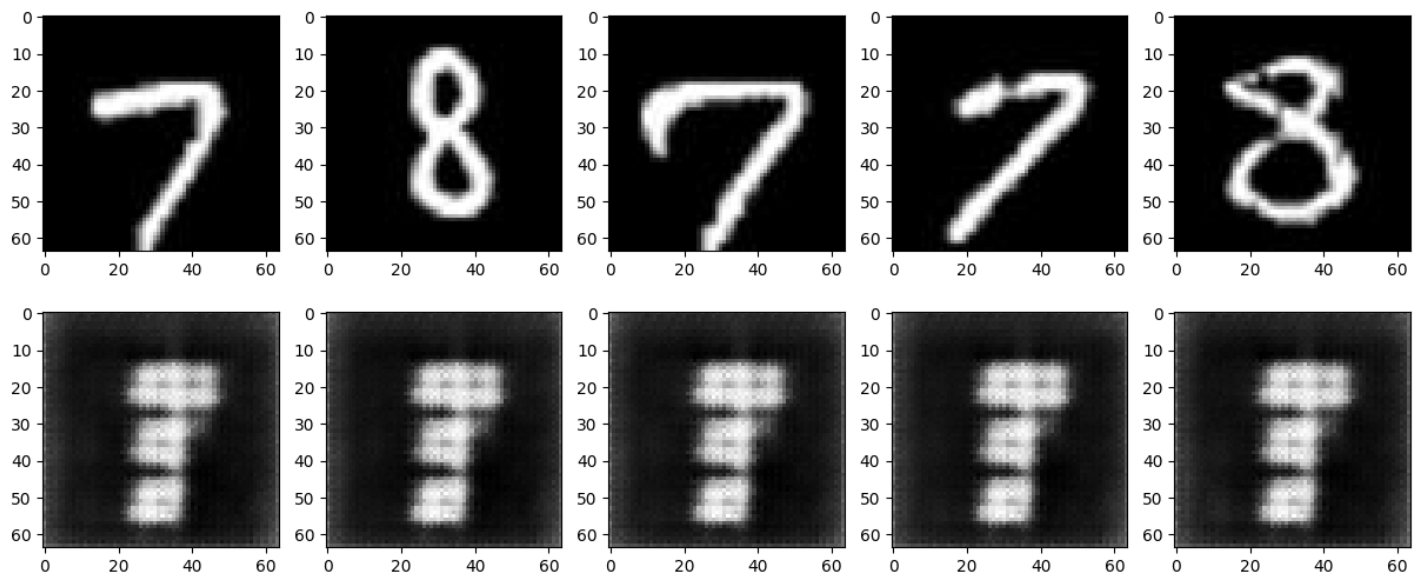

While generating images, I encountered a problem known as *Mode Collapse*.  

This occurs when the generator succeeds in fooling the discriminator by repeatedly generating similar-looking images, and ends up producing only those limited patterns.  

To address this issues, I tried;
* resetting the training environment (e.g., switching the computer device) 
* initializing the network (using `weights_init` function), 
* tuning hyperparameters such as the learning rate, batch size, and number of training epochs.

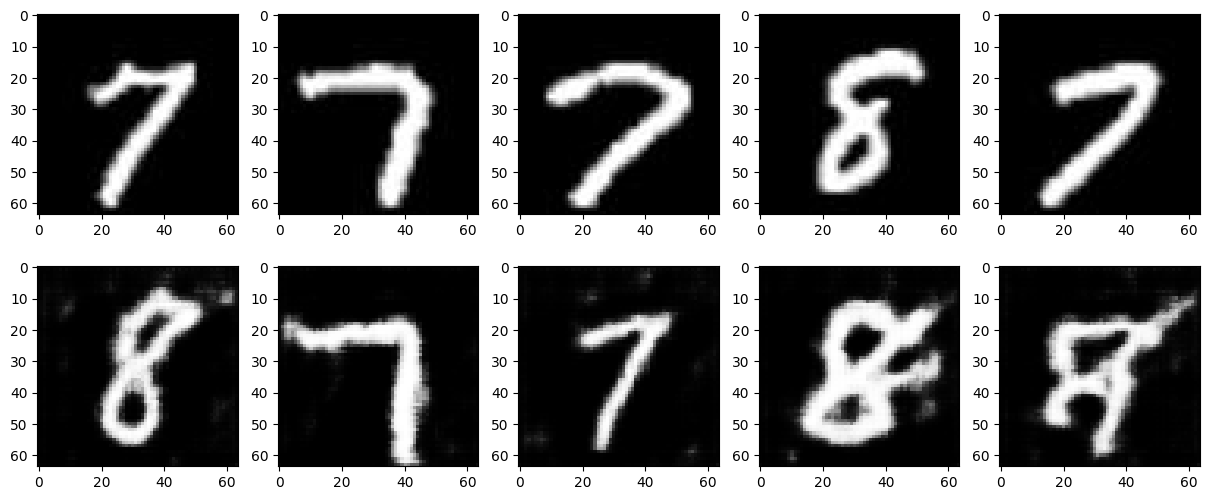

In [21]:
# Visualizing generated images

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# generaitng random numbers for input
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# generating image
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# training data
batch_iterator = iter(train_dataloader) # transform to iterator
images = next(batch_iterator) # extracting the first element

# output
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # show train image in upper row
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

    # show generated image in lower row
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

The top row shows training images, and the bottom row shows generated images.

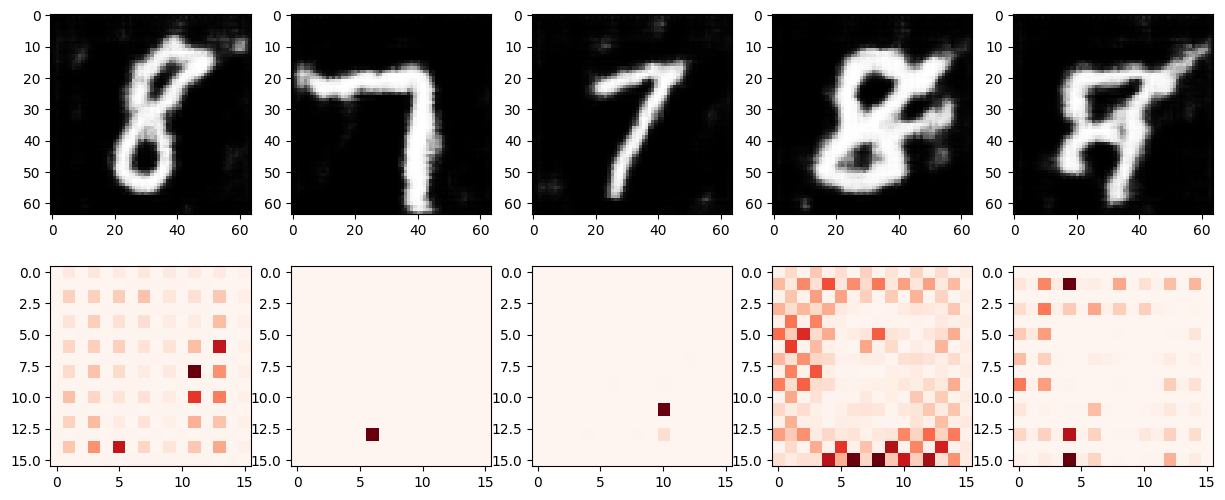

In [22]:
# output an attention map
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # show generated image in upper row
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # show attention map pixel data in lower row
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # A pixel at 7th row and 7th column
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

# Attention Map
The attention map shows how the pixel at position (7,7) -- which acts as the **query** -- attends to all other pixels in the 16x16 feature map.  

Pixels that are attended to are shown in **red**, while those that are not are shown in **white**.  

(All other pixels serves as **keys** corresponding to their values.)  

Now, let's try changing the query location.  

For example, let's take the pixel at position (7,7) and the pixel at position (5,12) as separate queries, and compute their respective attention maps by displaying them stacked vertically.  

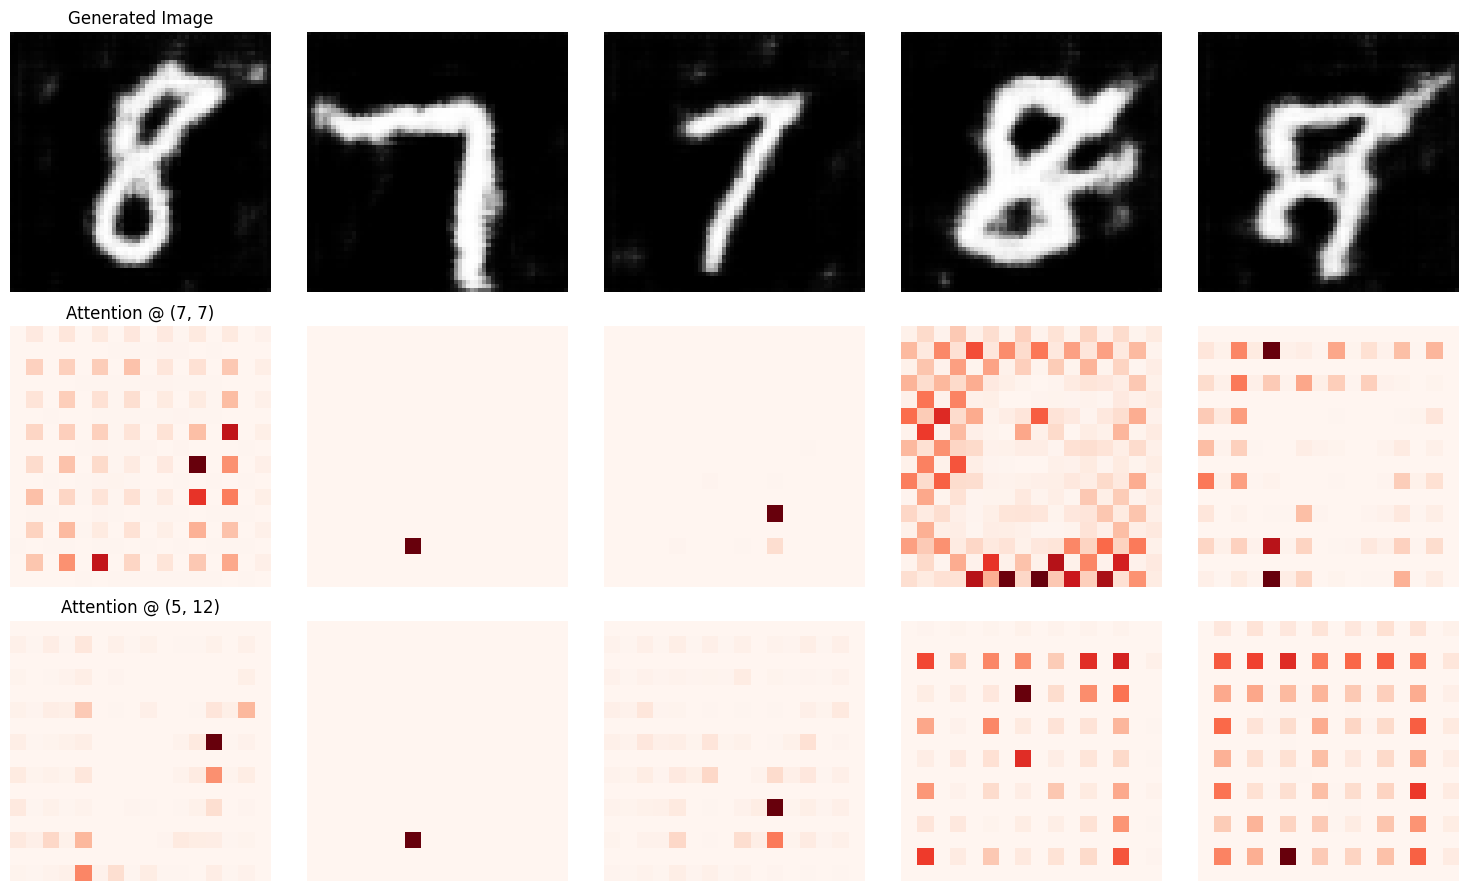

In [23]:
# output two attention maps with different query positions
fig = plt.figure(figsize=(15, 9))

for i in range(5):
    # show generated image (same for both attention maps)
    plt.subplot(3, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')
    if i == 0:
        plt.title("Generated Image")

    # Attention map for query at (7, 7)
    plt.subplot(3, 5, 5 + i + 1)
    am = am1[i].view(16, 16, 16, 16)
    am_7_7 = am[7][7]
    plt.imshow(am_7_7.cpu().detach().numpy(), 'Reds')
    plt.axis('off')
    if i == 0:
        plt.title("Attention @ (7, 7)")

    # Attention map for query at (5, 12)
    plt.subplot(3, 5, 10 + i + 1)
    am_5_12 = am[5][12]
    plt.imshow(am_5_12.cpu().detach().numpy(), 'Reds')
    plt.axis('off')
    if i == 0:
        plt.title("Attention @ (5, 12)")

plt.tight_layout()
plt.show()

Each pixel has its own unique attention map, which indicates that it builds independent relationships with other pixels.  

As training progresses and the number of epochs increases, the attention maps tend to become almost entirely white.  

This could be interpreted as the model no longer focusing on its attention on specific pixels once a certain level of learning has achieved. 

# Conclusion

DCGAN generates images by capturing local features through transposed convolution.  

However, this approach has a limitation: when local features are simply enlarged, it becomes difficult for the model to capture the global structure of the image.  

SAGAN addresses this issue by incorporating the attention mechanism, allowing each pixel to attend to the entire image during generation.  

Although Mode Collapse is a challenging problem, it can be mitigated by using Spectral Normalization to stabilize the update of weight parameters, along with fine-tuning of hyperparameters such as learning rate and batch-size by the programmer.  

Thank you for reading!  